# Apple Twitter Sentiment Analysis


## 0.1 Intent

In the following notebook we are going to be performing sentiment analysis on a collection of tweets about Apple Inc. The data can be obtained from the following link. After preprocessing, the tweets are labeled as either positive (i.e. I love my new iphone!) or negative. (i.e. Apple's customer service stinks!) We will conclude this write-up with an analysis of the words that are most indicative of a negative or positive tweet.

https://data.world/crowdflower/apple-twitter-sentiment



In [1]:
import nltk
import pandas as pd
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 0.2 Data Description

####  Tweet Sentiment
- Positive Sentiment = 1
- Negative Sentiment = 0

#### Sentiment: Confidence
- Range of [0,1] describing the confidence of the assignment.

#### Text
- Text composition of the tweet


## 0.3 Import the Dataset and Preview
The raw data comes with a lot of superfluous information that we do not need for this analysis. In this section we toss out these sections and end up with the DataFrame structure below.

In [2]:
os.chdir('C:\\Users\\Harrison\\Desktop\\APT')
df = pd.read_csv('train.csv', encoding='latin-1')


#dropping NaN and "dont care" response to setup a binary analysis.
df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']
df = df.reset_index()

#dropping the extra columns
df = df.drop(['index', '_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'date','id','query', 'sentiment_gold'], axis =1)

def encoder(x):
    #A simple class encoder to get to 1s and 0s for each of the sentiment
    if x=='5':
        return 1
    else:
        return 0

#Apply encoder to sentiment column
df['sentiment'] = df['sentiment'].apply(encoder)

df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
1,1,0.6736,CNBCTV: #Apple's margins better than expected?...
2,0,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
3,1,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
4,0,1.0000,@apple Contact sync between Yosemite and iOS8 ...


We also see that there is a class imbalance. We have 3 times as many negative tweets.

In [3]:
print('\n\nSentiment Values: ')
print(df.sentiment.value_counts())



Sentiment Values: 
0    1219
1     423
Name: sentiment, dtype: int64


# 1. Preprocessing

## 1.1 Clean the Data
Because the data is made up of Tweets, there are many non-text symbols throughout our dataset. This will only serve to confuse our model and make sentiment predictions less accurate. So we choose to make a simpler and potentially more accurate model by removing those symbols.

#### Symbols to be removed.
- url symbols (http:\)
- Twitter symbols (@, #)



In [4]:
from sklearn.model_selection import train_test_split

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_apple.csv')
df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
2,0,1.0000,wtf my battery was 31 one second ago and now ...
3,1,1.0000,rt bought my at the store pretty good logo...
4,0,1.0000,contact sync between yosemite and ios8 is ser...


##  1.2 Data Tokenization
Here we turn our twitter strings to lists of individual tokens. (words, punctuations)

In [5]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,sentiment,sentiment:confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


### 1.2.1 Sentence Length and Vocabulary Size
We have an average sentence length around 14-15 words, and a vocabulary size of 3,711 unique words.

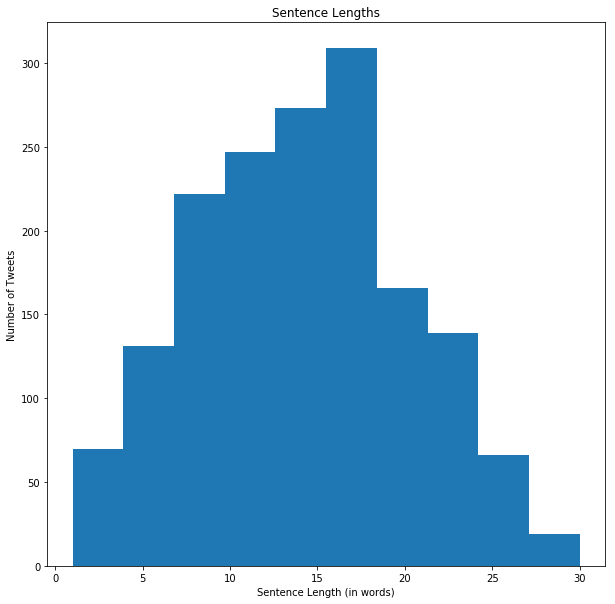

In [6]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens])))

plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [7]:
print('Words in vocab: ', len(vocab))

Words in vocab:  3701


## 1.3 Bag of Words
We will use TFIDF to convert our token lists to numerical data. 


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df[['text', 'sentiment:confidence']]
y = df['sentiment']

#splitting data for cross validation of model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=False)

#Keeping the assignment confidence for later
X_train_conf, X_test_conf = X_train['sentiment:confidence'], X_test['sentiment:confidence']
X_train, X_test = X_train['text'], X_test['text']

#saving to csv
X_train.to_csv('train_clean.csv')
X_test.to_csv('test_clean.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

print(X_train[:5])

0                    top 3 all   tablets  damn right! 
1    cnbctv   apple's margins better than expected?...
2    wtf my battery was 31  one second ago and now ...
3    rt  bought my  at the  store  pretty good logo...
4     contact sync between yosemite and ios8 is ser...
Name: text, dtype: object


In [13]:
#vectorization with TFIDF and scikit learn
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


#sparse matrix rows << columns
X_train_tfidf[0]

<1x3245 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

### 1.3.1 Visualizing our Dataset
We use a singular value decomposition to reduce our dataset to two dimensions. This will allow us to see any inherent linear seperability in the data that our model could capitalize on.

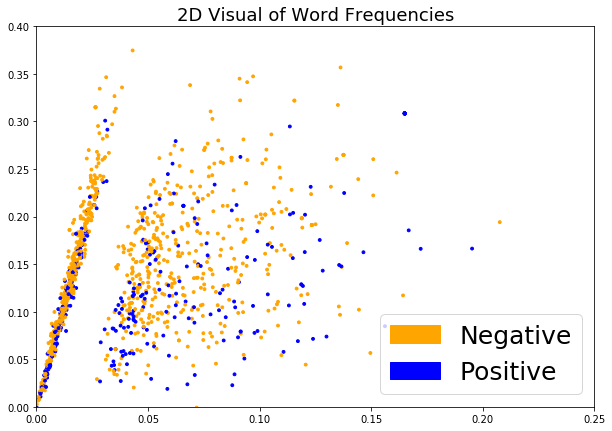

In [14]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Negative')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 25})
        
fig = plt.figure(figsize =(10,7))
plot_lsa(X_train_tfidf, y_train)
plt.xlim(0,0.25)
plt.ylim(0,0.4)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()

# 2. Model Building and Evaluation

## 2.1 Model Building
Here we will compare a simple logistic regression with a SVM that is tweaked with GridSearchCV.

In [20]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV()
logr.fit(X_train_tfidf, y_train)
y_pred_logr = logr.predict(X_test_tfidf)

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



clf = SVC(class_weight = 'balanced')
pipe = Pipeline([('classifier', clf)])
fit_params = {'classifier__kernel':['rbf', 'linear', 'poly'],
          'classifier__degree':[2, 3, 4],
          'classifier__C':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train_tfidf, y_train)


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'],
                classifier__kernel = gs.best_params_['classifier__kernel'],
               classifier__C = gs.best_params_['classifier__C'])
pipe.fit(X_train_tfidf, y_train)
y_pred = pipe.predict(X_test_tfidf)


Best performing classifier parameters (score 0.8377760853008378):
{'classifier__C': 1, 'classifier__degree': 2, 'classifier__kernel': 'linear'}


As we can see the best performing SVM had a linear kernel and default regularization strength. This might mean that in practice the best possible SVM and a simple Logistic Regression might be about the same.

## 2.2 Model Evaluation

Below we see that the Logistic Regression has a slight performance lead on the linear SVM. At 89% accuracy, we have built a model that is pretty good given the limited data we had. 

Guessing the most comon class would give 74.2% accurace, so our classifier is doing well. Note a fairly even precision and recall for both classes.

In [22]:
from sklearn.metrics import accuracy_score, classification_report

#Logistic Regression Eval
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred_logr))
print('\nLogistic Classification Report: \n' , classification_report(y_test,  y_pred_logr))

#SVM Eval
print('\n\n SVM Accuracy: ', accuracy_score(y_test, y_pred))
print('\nSVM Classification Report: \n' , classification_report(y_test,  y_pred))

Logistic Regression Accuracy:  0.8753799392097265

Logistic Classification Report: 
              precision    recall  f1-score   support

          0       0.89      0.95      0.92       244
          1       0.82      0.66      0.73        85

avg / total       0.87      0.88      0.87       329



 SVM Accuracy:  0.8541033434650456

SVM Classification Report: 
              precision    recall  f1-score   support

          0       0.90      0.91      0.90       244
          1       0.72      0.71      0.71        85

avg / total       0.85      0.85      0.85       329



### 2.2.1 Confusion Matrix
Our model has a preference towards giving false negatives rather than false positives. We look at some examples of misclassified tweets below.

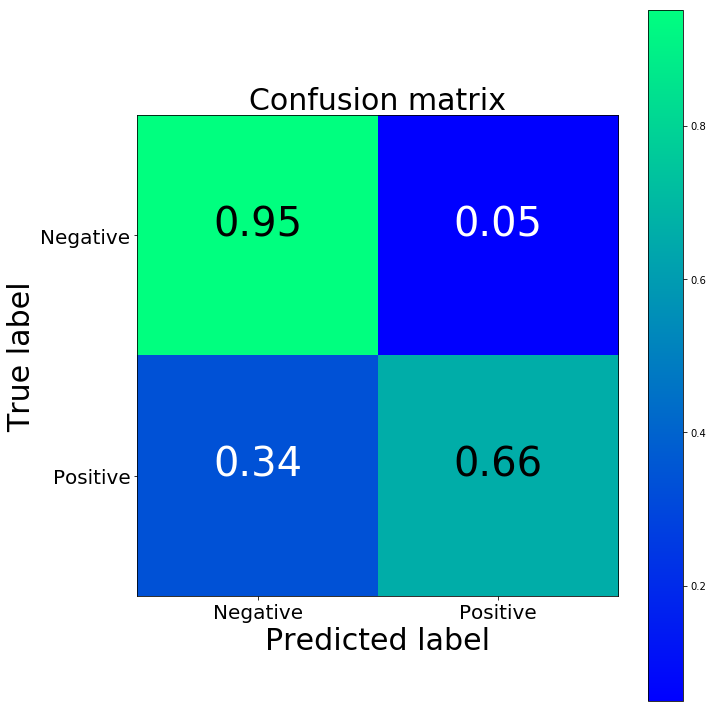

[[232  12]
 [ 29  56]]


In [23]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_pred_logr)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

#### Examples of False Negatives (Predicted Neg/Actual Pos)

In [24]:
def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives: ', fn.shape, '\n')
print(fn[:1].values, '\n')
print(fn[1:2].values, '\n')
print(fn[2:3].values, '\n')
print(fn[3:4].values)

Number of False Negatives:  (29,) 

["just updated my ram to 16gb   you guys are like shallow gf's  take all the money, but dammit you look good "] 

[' i think steve jobs would have been proud   icantbreathe '] 

['  this is so beautiful'] 

['first to own 2600 digital languages ip is new leader of the internet  terms based on performance!     ']


#### Examples of False Positives (Predicted Pos/ Actual Neg)

In [25]:
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives: ', fp.shape, '\n')
print(fp[:1].values, '\n')
print(fp[1:2].values, '\n')
print(fp[2:3].values, '\n')
print(fp[3:4].values)

Number of False Positives:  (12,) 

[' aapl shares fall despite price target increases from bmo capital and citigroup   apple  aapl  wallstreet  nasdaq'] 

['disgusted with  advertising for the ipad air   falseadvertising  nono'] 

["  named 'most desired brand' during  blackfriday  amp   cybermonday, beating  tech rival   via "] 

['fucka de you ']


### 2.2.2 Word Importances
As illustrated by the image below, our model clearly picks up on words that might predict s positive or negative tweet. Another interesting thing to note, "facetime" and "charger" are both words witha significant NEGATIVE connotation. Perhaps twitter users do not like these things?

In [26]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, logr, 10)

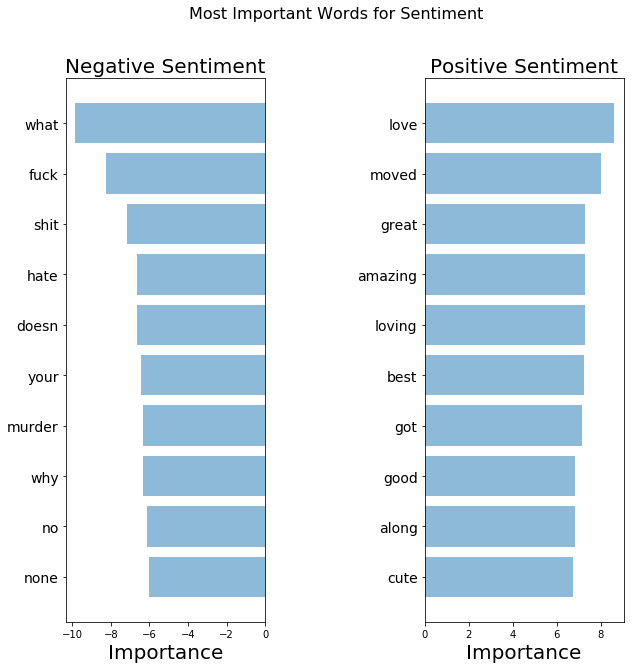

In [27]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")

# 3. Conclusion

We built a linear model that predicts the sentiment of tweets about Apple at around 89% accuracy.  The Confusion Matrix showed a tendency towards false negatives. Lastly we showed that the model succesfully inferred the importance of some english words to twitter sentiment.